# Data Preprocessing

# Import necessary libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from collections import Counter

### pandas:
Used for data manipulation and analysis. The DataFrame structure in pandas allows you to store and manipulate tabular data.
### numpy:
Useful for numerical computations, especially for working with arrays.
### matplotlib.pyplot:
A plotting library for creating visualizations (e.g., line graphs, scatter plots, etc.).
### seaborn:
Built on top of Matplotlib, Seaborn provides a high-level interface for creating attractive statistical visualizations.
### sklearn.preprocessing.StandardScaler:
Standardizes features by removing the mean and scaling to unit variance.
### sklearn.preprocessing.MinMaxScaler:
Scales features to a given range (typically between 0 and 1).
### sklearn.preprocessing.OneHotEncoder:
Converts categorical variables into a form that could be provided to ML algorithms to do better predictions.
### sklearn.impute.SimpleImputer:
Handles missing data by replacing it with a certain value (e.g., mean, median, or most frequent).
### sklearn.decomposition.PCA:
Implements Principal Component Analysis (PCA), which reduces the dimensionality of the dataset.
### sklearn.ensemble.IsolationForest:
Used for anomaly detection (detecting outliers).
### sklearn.model_selection.train_test_split:
Splits the dataset into training and testing sets.
### collections.Counter:
Counts the frequency of each element in a collection (useful for checking class balance).

# Dataset loading (for demonstration purposes, we use the Titanic dataset from seaborn)

In [10]:
df = sns.load_dataset("titanic")

# ====================
# 1. Data Cleaning
# ====================

# --- Checking for missing values ---

### Solution 1: Drop missing values (Not Recommended)

Remove any rows or columns that contain missing values.

Let's try to remove all rows that contain null values

### Solution 2: Filling the Missing Values - Imputation

The possible ways to do this are:
1- Filling the missing data with the mean or median value if it's a numerical variable.

2- Filling the missing data with mode if it's a categorical value.

3- Filling the categorical value with a new type for the missing values.


In [11]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


# Handling missing values using SimpleImputer
# Imputing numerical features with the median, categorical features with the most frequent value

In [12]:
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

# Applying imputers

In [15]:
df['age'] = imputer_num.fit_transform(df[['age']])
df['embarked'] = imputer_cat.fit_transform(df[['embarked']]).ravel()

In [16]:
print("\nAfter Imputation:")
print(df.isnull().sum())


After Imputation:
survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
embarked         0
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


# Dropping irrelevant columns (example: cabin is mostly null)

In [19]:
df_cleaned = df.drop(columns=['deck', 'embark_town'])

# ====================
# 2. Handling Outliers (Noise reduction)
# ====================

# --- Visualizing outliers using box plots ---

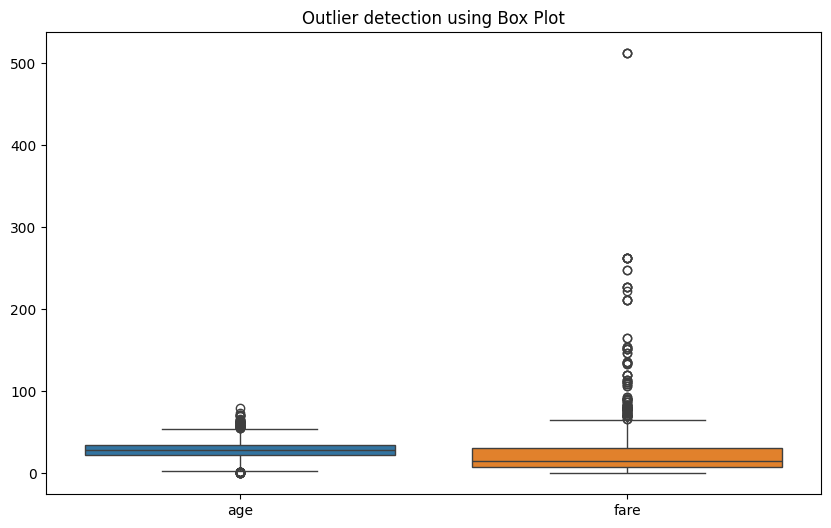

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned[['age', 'fare']])
plt.title("Outlier detection using Box Plot")
plt.show()

# --- Detecting outliers using Isolation Forest ---

In [21]:
iso_forest = IsolationForest(contamination=0.05)  # 5% contamination assumed for outliers
outliers = iso_forest.fit_predict(df_cleaned[['age', 'fare']])

# Labeling outliers (-1 means outlier)

In [22]:
df_cleaned['outlier'] = outliers
print(f"\nNumber of outliers detected: {(df_cleaned['outlier'] == -1).sum()}")


Number of outliers detected: 45


# Removing outliers

In [23]:
df_no_outliers = df_cleaned[df_cleaned['outlier'] != -1]

# ====================
# 3. Normalization and Scaling
# ====================

# --- Standardization (mean=0, variance=1) ---

In [24]:
scaler = StandardScaler()
df_scaled = df_no_outliers.copy()
df_scaled[['age', 'fare']] = scaler.fit_transform(df_no_outliers[['age', 'fare']])

In [25]:
print("\nStandardized age and fare:")
print(df_scaled[['age', 'fare']].head())


Standardized age and fare:
        age      fare
0 -0.563314 -0.683659
1  0.747108  1.892549
2 -0.235708 -0.656503
3  0.501404  1.160993
4  0.501404 -0.651473


# --- Min-Max Scaling (scaled to a range [0, 1]) ---

In [26]:
min_max_scaler = MinMaxScaler()
df_scaled[['age', 'fare']] = min_max_scaler.fit_transform(df_no_outliers[['age', 'fare']])

In [27]:
print("\nMin-Max Scaled age and fare:")
print(df_scaled[['age', 'fare']].head())


Min-Max Scaled age and fare:
        age      fare
0  0.329064  0.049481
1  0.573041  0.486506
2  0.390058  0.054088
3  0.527295  0.362406
4  0.527295  0.054941


# ====================
# 4. Handling Missing Values (Unbalanced Data)
# ====================

# --- Checking for class imbalance ---

In [28]:
print("\nClass distribution in 'survived' feature:")
print(df['survived'].value_counts())


Class distribution in 'survived' feature:
survived
0    549
1    342
Name: count, dtype: int64


# Using resampling to balance the classes

In [29]:
from sklearn.utils import resample

# Separate majority and minority classes

In [30]:
df_majority = df[df['survived'] == 0]
df_minority = df[df['survived'] == 1]

# Upsample minority class

In [31]:
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

# Combine majority class with upsampled minority class

In [32]:
df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [33]:
print("\nAfter balancing the classes:")
print(df_balanced['survived'].value_counts())


After balancing the classes:
survived
0    549
1    549
Name: count, dtype: int64


# ====================
# 5. Feature Engineering
# ====================

# --- One-Hot Encoding ---

In [34]:
encoder = OneHotEncoder(drop='first')  # Drop first to avoid multicollinearity
encoded_columns = pd.DataFrame(encoder.fit_transform(df_balanced[['sex', 'embarked']]).toarray(), columns=encoder.get_feature_names_out(['sex', 'embarked']))

# Adding the encoded columns to the dataset

In [35]:
df_encoded = df_balanced.join(encoded_columns).drop(columns=['sex', 'embarked'])
print("\nAfter One-Hot Encoding:")
print(df_encoded.head())


After One-Hot Encoding:
   survived  pclass   age  sibsp  parch     fare  class    who  adult_male  \
0         0       3  22.0      1      0   7.2500  Third    man        True   
4         0       3  35.0      0      0   8.0500  Third    man        True   
5         0       3  28.0      0      0   8.4583  Third    man        True   
6         0       1  54.0      0      0  51.8625  First    man        True   
7         0       3   2.0      3      1  21.0750  Third  child       False   

  deck  embark_town alive  alone  sex_male  embarked_Q  embarked_S  
0  NaN  Southampton    no  False       1.0         0.0         1.0  
4  NaN  Southampton    no   True       1.0         0.0         1.0  
5  NaN   Queenstown    no   True       1.0         0.0         1.0  
6    E  Southampton    no   True       1.0         0.0         1.0  
7  NaN  Southampton    no  False       0.0         0.0         1.0  


# ====================
# 6. Dimensionality Reduction
# ====================

# --- Principal Component Analysis (PCA) ---
# We reduce the dataset to 2 principal components for visualization

In [40]:
# Select only numerical features for PCA
numerical_features = df_encoded.select_dtypes(include=['number']).drop(columns=['survived'])

# Scale the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

# Apply PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'], index=df_encoded.index)

# Concatenate the PCA components with the original DataFrame
df_encoded_pca = pd.concat([df_encoded, pca_df], axis=1)

print("\nAfter PCA:")
print(df_encoded_pca.head())


After PCA:
   survived  pclass   age  sibsp  parch     fare  class    who  adult_male  \
0         0       3  22.0      1      0   7.2500  Third    man        True   
4         0       3  35.0      0      0   8.0500  Third    man        True   
5         0       3  28.0      0      0   8.4583  Third    man        True   
6         0       1  54.0      0      0  51.8625  First    man        True   
7         0       3   2.0      3      1  21.0750  Third  child       False   

  deck  embark_town alive  alone  sex_male  embarked_Q  embarked_S       PC1  \
0  NaN  Southampton    no  False       1.0         0.0         1.0  1.369204   
4  NaN  Southampton    no   True       1.0         0.0         1.0  1.087300   
5  NaN   Queenstown    no   True       1.0         0.0         1.0  1.258583   
6    E  Southampton    no   True       1.0         0.0         1.0 -1.323070   
7  NaN  Southampton    no  False       0.0         0.0         1.0  1.299573   

        PC2  
0  0.390573  
4 -0.37512

In [41]:
print("\nExplained Variance by PCA components:")
print(pca.explained_variance_ratio_)


Explained Variance by PCA components:
[0.21878544 0.20703076]


# Visualizing the PCA components

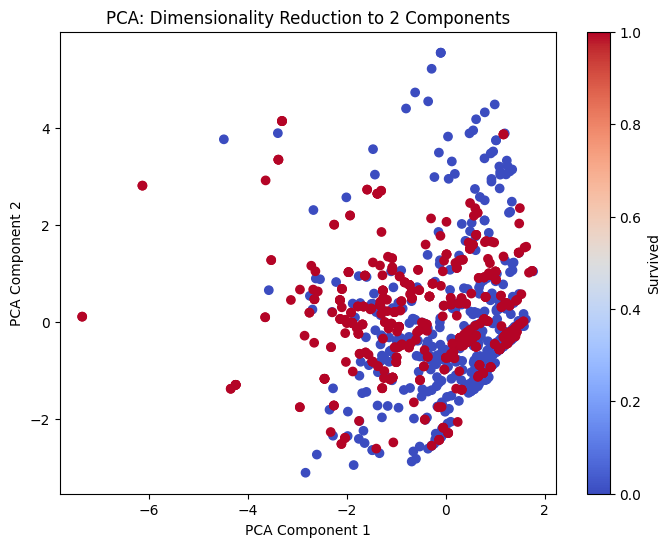

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df_encoded['survived'], cmap='coolwarm')
plt.title("PCA: Dimensionality Reduction to 2 Components")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Survived")
plt.show()

In [43]:
print("\nData Preprocessing is complete. The dataset has been cleaned, scaled, and processed for further analysis.")


Data Preprocessing is complete. The dataset has been cleaned, scaled, and processed for further analysis.


### 1. Data Cleaning:

Detect and impute missing values for numerical (using median) and categorical (using the most frequent) columns.
Dropped irrelevant columns with excessive missing values (like 'cabin').


### 2. Handling Outliers:

Visualized outliers using a boxplot for features like age and fare.
Used Isolation Forest to detect and remove outliers.


### 3. Normalization and Scaling:

Applied both standardization and Min-Max scaling to numerical columns (age and fare) to demonstrate the differences.


### 4. Handling Unbalanced Data:

Checked the class imbalance in the survived feature and balanced the classes using upsampling.


### 5. Feature Engineering:

Demonstrated one-hot encoding for categorical variables (sex and embarked), avoiding multicollinearity by dropping the first category.


### 6. Dimensionality Reduction:

Performed Principal Component Analysis (PCA) to reduce the dataset's dimensionality to two principal components and visualized the result.